# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 100 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-6,4e-6,0.5e-6, 5e-5]
regularization_strengths = [5e4, 5e5, 5e6, 1e4, 2e4, 2.5e4,2.7e4, 3e4,3.3e4, 4e4, 5e4]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for l in learning_rates:
    for r in regularization_strengths:
        svm=LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=l, reg=r,num_iters=5000,verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        train_accuracy=np.mean(y_train == y_train_pred)
        val_accuracy=np.mean(y_val == y_val_pred)
        results[(l,r)]=( train_accuracy, val_accuracy )
        if best_val < val_accuracy:
            best_val=val_accuracy
            best_svm=svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 5.000000e-07 reg 1.000000e+04 train accuracy: 0.326653 val accuracy: 0.302000
lr 5.000000e-07 reg 2.000000e+04 train accuracy: 0.325082 val accuracy: 0.355000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.323878 val accuracy: 0.347000
lr 5.000000e-07 reg 2.700000e+04 train accuracy: 0.313673 val accuracy: 0.323000
lr 5.000000e-07 reg 3.000000e+04 train accuracy: 0.301408 val accuracy: 0.323000
lr 5.000000e-07 reg 3.300000e+04 train accuracy: 0.325020 val accuracy: 0.353000
lr 5.000000e-07 reg 4.000000e+04 train accuracy: 0.329367 val accuracy: 0.333000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.320551 val accuracy: 0.320000
lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.321551 val accuracy: 0.326000
lr 5.000000e-07 reg 5.000000e+06 train accuracy: 0.323592 val accuracy: 0.323000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.374673 val accuracy: 0.386000
lr 1.000000e-06 reg 2.000000e+04 train accuracy: 0.384000 val accuracy: 0.383000
lr 1.000000e-06 reg 2.500000

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.465


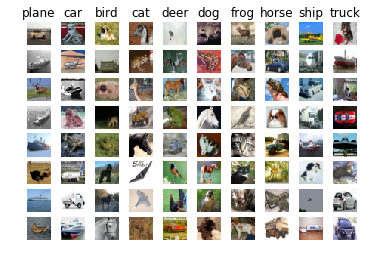

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

** Answer **

yes,misclassifications make sense
birds sometimes classified as planes because usually both hava a sky background and the algorithm classifies base on that cyan color
also in case of dear, other animals are classified as dear just because of those green backgrounds and some little similar features
so they makes sense because classifications are based partiallu on color histograms as features

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 245)
(49000, 244)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet
from sklearn.decomposition import PCA
input_dim = X_train_feats.shape[1]
input_size = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
import tqdm
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

learning_rates = [1e-7,1e-5,1e-4,1e-3,0.01]
hidden_sizes = [100, 150,225, 300]
iterations=[50,100,300,700,1000]
batches=[50,100,300,500]
regulars=[5,0.5,0.05,0.005,0.0005,5e-5,5e-6]
best_val = -1
loop_num=1
flag_reduced= False
for l in tqdm.tqdm(learning_rates):
        print("learning rate: ", l)
        for it in tqdm.tqdm(iterations):
            for b in tqdm.tqdm(batches):
                for h in hidden_sizes:
                    for r in regulars:
                        net = TwoLayerNet(X_val_feats.shape[1], h, num_classes)
                        #tuning over 10% of training set
                        net.train(X_train_feats[:5000], y_train[:5000], X_val_feats, y_val,num_iters=it, batch_size=b,learning_rate=l,
                                  learning_rate_decay=0.95,reg=r,verbose=False)
                        y_train_pred = net.predict(X_train_feats)
                        y_val_pred = net.predict(X_val_feats)
                        train_accuracy=np.mean(y_train == y_train_pred)
                        val_accuracy=np.mean(y_val == y_val_pred)
                        loop_num+=1
                        print("learning rate: " , l, "hidden: ",h,"batch: ",b,"reg",r," iterations: ",it,"accuracy: ",val_accuracy)
                        if best_val < val_accuracy:
                                    best_val = val_accuracy
                                    best_net = net
                                    #print("learning rate: " , l, "hidden: ",h,"batch: ",b,"reg",reg," iterations: ",it,"accuracy: ",best_val)

net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=it, batch_size=b,learning_rate=l,learning_rate_decay=0.95,reg=r,verbose=False)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
'''

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

'''

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

learning rate:  1e-07
learning rate:  1e-07 hidden:  100 batch:  50 reg 5  iterations:  50 accuracy:  0.082
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.5  iterations:  50 accuracy:  0.092
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.05  iterations:  50 accuracy:  0.122
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.005  iterations:  50 accuracy:  0.104
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.0005  iterations:  50 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-05  iterations:  50 accuracy:  0.122
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-06  iterations:  50 accuracy:  0.111
learning rate:  1e-07 hidden:  150 batch:  50 reg 5  iterations:  50 accuracy:  0.105
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.5  iterations:  50 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.05  iterations:  50 accuracy:  0.118
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.005  iterations:  50 accuracy:  0.099
le



 25%|██▌       | 1/4 [00:17<00:52, 17.57s/it]

learning rate:  1e-07 hidden:  300 batch:  50 reg 5e-06  iterations:  50 accuracy:  0.089
learning rate:  1e-07 hidden:  100 batch:  100 reg 5  iterations:  50 accuracy:  0.107
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.5  iterations:  50 accuracy:  0.101
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.05  iterations:  50 accuracy:  0.104
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.005  iterations:  50 accuracy:  0.106
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.0005  iterations:  50 accuracy:  0.094
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-05  iterations:  50 accuracy:  0.108
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-06  iterations:  50 accuracy:  0.067
learning rate:  1e-07 hidden:  150 batch:  100 reg 5  iterations:  50 accuracy:  0.109
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.5  iterations:  50 accuracy:  0.079
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.05  iterations:  50 accuracy:  0.106
learning rate



 50%|█████     | 2/4 [00:35<00:35, 17.67s/it]

learning rate:  1e-07 hidden:  300 batch:  100 reg 5e-06  iterations:  50 accuracy:  0.111
learning rate:  1e-07 hidden:  100 batch:  300 reg 5  iterations:  50 accuracy:  0.126
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.5  iterations:  50 accuracy:  0.096
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.05  iterations:  50 accuracy:  0.093
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.005  iterations:  50 accuracy:  0.134
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.0005  iterations:  50 accuracy:  0.119
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-05  iterations:  50 accuracy:  0.118
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-06  iterations:  50 accuracy:  0.102
learning rate:  1e-07 hidden:  150 batch:  300 reg 5  iterations:  50 accuracy:  0.075
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.5  iterations:  50 accuracy:  0.112
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.05  iterations:  50 accuracy:  0.096
learning rat



 75%|███████▌  | 3/4 [00:56<00:18, 18.78s/it]

learning rate:  1e-07 hidden:  300 batch:  300 reg 5e-06  iterations:  50 accuracy:  0.143
learning rate:  1e-07 hidden:  100 batch:  500 reg 5  iterations:  50 accuracy:  0.089
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.5  iterations:  50 accuracy:  0.126
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.05  iterations:  50 accuracy:  0.112
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.005  iterations:  50 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.0005  iterations:  50 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-05  iterations:  50 accuracy:  0.097
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-06  iterations:  50 accuracy:  0.11
learning rate:  1e-07 hidden:  150 batch:  500 reg 5  iterations:  50 accuracy:  0.116
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.5  iterations:  50 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.05  iterations:  50 accuracy:  0.1
learning rate:  1



100%|██████████| 4/4 [01:26<00:00, 22.08s/it]


 20%|██        | 1/5 [01:26<05:46, 86.62s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

learning rate:  1e-07 hidden:  300 batch:  500 reg 5e-06  iterations:  50 accuracy:  0.099
learning rate:  1e-07 hidden:  100 batch:  50 reg 5  iterations:  100 accuracy:  0.075
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.5  iterations:  100 accuracy:  0.1
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.05  iterations:  100 accuracy:  0.078
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.005  iterations:  100 accuracy:  0.108
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.0005  iterations:  100 accuracy:  0.134
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-05  iterations:  100 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-06  iterations:  100 accuracy:  0.108
learning rate:  1e-07 hidden:  150 batch:  50 reg 5  iterations:  100 accuracy:  0.11
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.5  iterations:  100 accuracy:  0.112
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.05  iterations:  100 accuracy:  0.094
learning rate:  



 25%|██▌       | 1/4 [00:20<01:00, 20.02s/it]

learning rate:  1e-07 hidden:  300 batch:  50 reg 5e-06  iterations:  100 accuracy:  0.091
learning rate:  1e-07 hidden:  100 batch:  100 reg 5  iterations:  100 accuracy:  0.078
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.5  iterations:  100 accuracy:  0.104
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.05  iterations:  100 accuracy:  0.109
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.005  iterations:  100 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.0005  iterations:  100 accuracy:  0.113
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-05  iterations:  100 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-06  iterations:  100 accuracy:  0.11
learning rate:  1e-07 hidden:  150 batch:  100 reg 5  iterations:  100 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.5  iterations:  100 accuracy:  0.113
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.05  iterations:  100 accuracy:  0.079
lea



 50%|█████     | 2/4 [00:42<00:41, 20.90s/it]

learning rate:  1e-07 hidden:  300 batch:  100 reg 5e-06  iterations:  100 accuracy:  0.103
learning rate:  1e-07 hidden:  100 batch:  300 reg 5  iterations:  100 accuracy:  0.085
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.5  iterations:  100 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.05  iterations:  100 accuracy:  0.119
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.005  iterations:  100 accuracy:  0.1
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.0005  iterations:  100 accuracy:  0.098
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-05  iterations:  100 accuracy:  0.07
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-06  iterations:  100 accuracy:  0.101
learning rate:  1e-07 hidden:  150 batch:  300 reg 5  iterations:  100 accuracy:  0.078
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.5  iterations:  100 accuracy:  0.1
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.05  iterations:  100 accuracy:  0.139
learnin



 75%|███████▌  | 3/4 [01:15<00:24, 24.50s/it]

learning rate:  1e-07 hidden:  300 batch:  300 reg 5e-06  iterations:  100 accuracy:  0.102
learning rate:  1e-07 hidden:  100 batch:  500 reg 5  iterations:  100 accuracy:  0.071
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.5  iterations:  100 accuracy:  0.128
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.05  iterations:  100 accuracy:  0.105
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.005  iterations:  100 accuracy:  0.113
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.0005  iterations:  100 accuracy:  0.119
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-05  iterations:  100 accuracy:  0.084
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-06  iterations:  100 accuracy:  0.107
learning rate:  1e-07 hidden:  150 batch:  500 reg 5  iterations:  100 accuracy:  0.121
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.5  iterations:  100 accuracy:  0.101
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.05  iterations:  100 accuracy:  0.082
l



100%|██████████| 4/4 [02:03<00:00, 31.30s/it]


 40%|████      | 2/5 [03:29<04:52, 97.55s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

learning rate:  1e-07 hidden:  300 batch:  500 reg 5e-06  iterations:  100 accuracy:  0.084
learning rate:  1e-07 hidden:  100 batch:  50 reg 5  iterations:  300 accuracy:  0.081
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.5  iterations:  300 accuracy:  0.099
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.05  iterations:  300 accuracy:  0.118
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.005  iterations:  300 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.0005  iterations:  300 accuracy:  0.121
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-05  iterations:  300 accuracy:  0.112
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-06  iterations:  300 accuracy:  0.098
learning rate:  1e-07 hidden:  150 batch:  50 reg 5  iterations:  300 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.5  iterations:  300 accuracy:  0.101
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.05  iterations:  300 accuracy:  0.11
learning rat



 25%|██▌       | 1/4 [00:31<01:33, 31.10s/it]

learning rate:  1e-07 hidden:  300 batch:  50 reg 5e-06  iterations:  300 accuracy:  0.101
learning rate:  1e-07 hidden:  100 batch:  100 reg 5  iterations:  300 accuracy:  0.111
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.5  iterations:  300 accuracy:  0.093
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.05  iterations:  300 accuracy:  0.115
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.005  iterations:  300 accuracy:  0.097
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.0005  iterations:  300 accuracy:  0.112
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-05  iterations:  300 accuracy:  0.073
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-06  iterations:  300 accuracy:  0.094
learning rate:  1e-07 hidden:  150 batch:  100 reg 5  iterations:  300 accuracy:  0.104
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.5  iterations:  300 accuracy:  0.08
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.05  iterations:  300 accuracy:  0.101
lea



 50%|█████     | 2/4 [01:12<01:08, 34.12s/it]

learning rate:  1e-07 hidden:  300 batch:  100 reg 5e-06  iterations:  300 accuracy:  0.091
learning rate:  1e-07 hidden:  100 batch:  300 reg 5  iterations:  300 accuracy:  0.107
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.5  iterations:  300 accuracy:  0.089
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.05  iterations:  300 accuracy:  0.118
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.005  iterations:  300 accuracy:  0.082
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.0005  iterations:  300 accuracy:  0.101
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-05  iterations:  300 accuracy:  0.099
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-06  iterations:  300 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  300 reg 5  iterations:  300 accuracy:  0.111
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.5  iterations:  300 accuracy:  0.131
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.05  iterations:  300 accuracy:  0.08
le



 75%|███████▌  | 3/4 [02:15<00:42, 42.84s/it]

learning rate:  1e-07 hidden:  300 batch:  300 reg 5e-06  iterations:  300 accuracy:  0.1
learning rate:  1e-07 hidden:  100 batch:  500 reg 5  iterations:  300 accuracy:  0.091
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.5  iterations:  300 accuracy:  0.091
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.05  iterations:  300 accuracy:  0.092
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.005  iterations:  300 accuracy:  0.106
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.0005  iterations:  300 accuracy:  0.112
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-05  iterations:  300 accuracy:  0.107
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-06  iterations:  300 accuracy:  0.11
learning rate:  1e-07 hidden:  150 batch:  500 reg 5  iterations:  300 accuracy:  0.107
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.5  iterations:  300 accuracy:  0.084
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.05  iterations:  300 accuracy:  0.072
lear



100%|██████████| 4/4 [04:20<00:00, 67.62s/it]


 60%|██████    | 3/5 [07:50<04:53, 146.56s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

learning rate:  1e-07 hidden:  300 batch:  500 reg 5e-06  iterations:  300 accuracy:  0.08
learning rate:  1e-07 hidden:  100 batch:  50 reg 5  iterations:  700 accuracy:  0.084
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.5  iterations:  700 accuracy:  0.108
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.05  iterations:  700 accuracy:  0.114
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.005  iterations:  700 accuracy:  0.062
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.0005  iterations:  700 accuracy:  0.101
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-05  iterations:  700 accuracy:  0.077
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-06  iterations:  700 accuracy:  0.132
learning rate:  1e-07 hidden:  150 batch:  50 reg 5  iterations:  700 accuracy:  0.108
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.5  iterations:  700 accuracy:  0.08
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.05  iterations:  700 accuracy:  0.08
learning rate:



 25%|██▌       | 1/4 [00:50<02:30, 50.33s/it]

learning rate:  1e-07 hidden:  300 batch:  50 reg 5e-06  iterations:  700 accuracy:  0.087
learning rate:  1e-07 hidden:  100 batch:  100 reg 5  iterations:  700 accuracy:  0.093
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.5  iterations:  700 accuracy:  0.083
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.05  iterations:  700 accuracy:  0.102
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.005  iterations:  700 accuracy:  0.094
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.0005  iterations:  700 accuracy:  0.108
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-05  iterations:  700 accuracy:  0.089
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-06  iterations:  700 accuracy:  0.065
learning rate:  1e-07 hidden:  150 batch:  100 reg 5  iterations:  700 accuracy:  0.092
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.5  iterations:  700 accuracy:  0.107
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.05  iterations:  700 accuracy:  0.097
le



 50%|█████     | 2/4 [01:59<01:51, 55.96s/it]

learning rate:  1e-07 hidden:  300 batch:  100 reg 5e-06  iterations:  700 accuracy:  0.094
learning rate:  1e-07 hidden:  100 batch:  300 reg 5  iterations:  700 accuracy:  0.094
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.5  iterations:  700 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.05  iterations:  700 accuracy:  0.105
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.005  iterations:  700 accuracy:  0.082
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.0005  iterations:  700 accuracy:  0.069
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-05  iterations:  700 accuracy:  0.07
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-06  iterations:  700 accuracy:  0.109
learning rate:  1e-07 hidden:  150 batch:  300 reg 5  iterations:  700 accuracy:  0.106
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.5  iterations:  700 accuracy:  0.117
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.05  iterations:  700 accuracy:  0.097
le



 75%|███████▌  | 3/4 [04:08<01:17, 77.84s/it]

learning rate:  1e-07 hidden:  300 batch:  300 reg 5e-06  iterations:  700 accuracy:  0.089
learning rate:  1e-07 hidden:  100 batch:  500 reg 5  iterations:  700 accuracy:  0.1
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.5  iterations:  700 accuracy:  0.08
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.05  iterations:  700 accuracy:  0.076
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.005  iterations:  700 accuracy:  0.117
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.0005  iterations:  700 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-05  iterations:  700 accuracy:  0.121
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-06  iterations:  700 accuracy:  0.106
learning rate:  1e-07 hidden:  150 batch:  500 reg 5  iterations:  700 accuracy:  0.084
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.5  iterations:  700 accuracy:  0.113
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.05  iterations:  700 accuracy:  0.079
learn



100%|██████████| 4/4 [07:42<00:00, 118.85s/it]


 80%|████████  | 4/5 [15:33<04:01, 241.46s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

learning rate:  1e-07 hidden:  300 batch:  500 reg 5e-06  iterations:  700 accuracy:  0.12
learning rate:  1e-07 hidden:  100 batch:  50 reg 5  iterations:  1000 accuracy:  0.16
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.5  iterations:  1000 accuracy:  0.082
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.05  iterations:  1000 accuracy:  0.109
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.005  iterations:  1000 accuracy:  0.072
learning rate:  1e-07 hidden:  100 batch:  50 reg 0.0005  iterations:  1000 accuracy:  0.099
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-05  iterations:  1000 accuracy:  0.13
learning rate:  1e-07 hidden:  100 batch:  50 reg 5e-06  iterations:  1000 accuracy:  0.095
learning rate:  1e-07 hidden:  150 batch:  50 reg 5  iterations:  1000 accuracy:  0.094
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.5  iterations:  1000 accuracy:  0.098
learning rate:  1e-07 hidden:  150 batch:  50 reg 0.05  iterations:  1000 accuracy:  0.08
learn



 25%|██▌       | 1/4 [01:04<03:12, 64.01s/it]

learning rate:  1e-07 hidden:  300 batch:  50 reg 5e-06  iterations:  1000 accuracy:  0.114
learning rate:  1e-07 hidden:  100 batch:  100 reg 5  iterations:  1000 accuracy:  0.099
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.5  iterations:  1000 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.05  iterations:  1000 accuracy:  0.125
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.005  iterations:  1000 accuracy:  0.123
learning rate:  1e-07 hidden:  100 batch:  100 reg 0.0005  iterations:  1000 accuracy:  0.106
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-05  iterations:  1000 accuracy:  0.107
learning rate:  1e-07 hidden:  100 batch:  100 reg 5e-06  iterations:  1000 accuracy:  0.086
learning rate:  1e-07 hidden:  150 batch:  100 reg 5  iterations:  1000 accuracy:  0.1
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.5  iterations:  1000 accuracy:  0.109
learning rate:  1e-07 hidden:  150 batch:  100 reg 0.05  iterations:  1000 accuracy: 



 50%|█████     | 2/4 [02:32<02:22, 71.38s/it]

learning rate:  1e-07 hidden:  300 batch:  100 reg 5e-06  iterations:  1000 accuracy:  0.088
learning rate:  1e-07 hidden:  100 batch:  300 reg 5  iterations:  1000 accuracy:  0.094
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.5  iterations:  1000 accuracy:  0.11
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.05  iterations:  1000 accuracy:  0.083
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.005  iterations:  1000 accuracy:  0.109
learning rate:  1e-07 hidden:  100 batch:  300 reg 0.0005  iterations:  1000 accuracy:  0.138
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-05  iterations:  1000 accuracy:  0.074
learning rate:  1e-07 hidden:  100 batch:  300 reg 5e-06  iterations:  1000 accuracy:  0.098
learning rate:  1e-07 hidden:  150 batch:  300 reg 5  iterations:  1000 accuracy:  0.105
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.5  iterations:  1000 accuracy:  0.115
learning rate:  1e-07 hidden:  150 batch:  300 reg 0.05  iterations:  1000 accuracy



 75%|███████▌  | 3/4 [05:29<01:43, 103.08s/it]

learning rate:  1e-07 hidden:  300 batch:  300 reg 5e-06  iterations:  1000 accuracy:  0.079
learning rate:  1e-07 hidden:  100 batch:  500 reg 5  iterations:  1000 accuracy:  0.12
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.5  iterations:  1000 accuracy:  0.096
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.05  iterations:  1000 accuracy:  0.104
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.005  iterations:  1000 accuracy:  0.115
learning rate:  1e-07 hidden:  100 batch:  500 reg 0.0005  iterations:  1000 accuracy:  0.086
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-05  iterations:  1000 accuracy:  0.084
learning rate:  1e-07 hidden:  100 batch:  500 reg 5e-06  iterations:  1000 accuracy:  0.089
learning rate:  1e-07 hidden:  150 batch:  500 reg 5  iterations:  1000 accuracy:  0.098
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.5  iterations:  1000 accuracy:  0.091
learning rate:  1e-07 hidden:  150 batch:  500 reg 0.05  iterations:  1000 accuracy

In [ ]:
# from cs231n.classifiers.neural_net import TwoLayerNet

# input_dim = X_train_feats.shape[1]
# input_size = X_train_feats.shape[1]
# hidden_dim = 500
# num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None

# ################################################################################
# # TODO: Train a two-layer neural network on image features. You may want to    #
# # cross-validate various parameters as in previous sections. Store your best   #
# # model in the best_net variable.                                              #
# ################################################################################

# learning_rates = [1e-7,1e-5,1e-5,1e-3,0.01]
# hidden_sizes = [100, 150, 300]
# iterations=[50,100,300,700,100]
# batches=[50,100,300,500]
# regulars=[5,0.5,0.05,0.005,0.0005]
# best_val = -1
# loop_num=1
# flag_reduced= False
# for l in learning_rates:
#         print("learning rate: ", l)
#         for it in iterations:
#             for b in batches:
#                 for h in hidden_sizes:
#                     for r in regulars:
#                         if loop_num == len(learning_rates)*len(hidden_sizes):
#                             pca = PCA()  
#                             X_train = pca.fit_transform(X_train_feats)
#                             X_val= pca.transform(X_val_feats)
#                             flag_reduced=True
#                             net = TwoLayerNet(X_train_feats.shape[1], h, num_classes)
#                         else:
#                             net = TwoLayerNet(input_size, h, num_classes)



#                         net.train(X_train_feats, y_train, X_val_feats, y_val,num_iters=it, batch_size=b,learning_rate=l,
#                                   learning_rate_decay=0.95,reg=r,verbose=False)
#                         y_train_pred = net.predict(X_train_feats)
#                         y_val_pred = net.predict(X_val_feats)
#                         train_accuracy=np.mean(y_train == y_train_pred)
#                         val_accuracy=np.mean(y_val == y_val_pred)
#                         loop_num+=1
#                         if best_val < val_accuracy:
#                                     if flag_reduced:
#                                         print('PCA applied for better val_accuracy')
#                                     best_val = val_accuracy
#                                     best_net = net
#                                     print("learning rate: " , l, "hidden: ",h,"batch: ",b,"reg",reg," iterations: ",it,"accuracy: ",best_val)
# ################################################################################
# #                              END OF YOUR CODE                                #
# ################################################################################
# '''

# # Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
# print('best validation accuracy achieved during cross-validation: %f' % best_val)

# '''

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)